<a href="https://colab.research.google.com/github/aytnihca/509-Project/blob/main/Copy_of_Homework_5_Problems.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
%pylab inline
%config InlineBackend.figure_format = 'retina'
from ipywidgets import interact
import scipy.stats as stats
import pandas as pd
import pymc as pm
import arviz as az

Populating the interactive namespace from numpy and matplotlib


# Q1
It is sometimes observed that the best predictor of fire risk is the presence of firefighters—States and localities with many firefighters also have more fires. Presumably firefighters do not cause fires. Nevertheless, this is not a spurious correlation. Instead fires cause firefighters. Consider the same reversal of causal inference in the context of the divorce and marriage data. How might a high divorce rate cause a higher marriage rate? Can you think of a way to evaluate this relationship using multiple regression?

Divorce rates will cause hogher marriages rates. This is because if in a society, people are less likely to stay single, then getting divorced more will not stop people from remarrying. This will cause higher marriage rates. We can use multiple regression to evaluate how marriage rate is influenced by the divorce rate and the rate at which people remarry.

# Q2
In the divorce data, States with high numbers of Mormons (members of The Church of Jesus Christ of Latter-day Saints, LDS) have much lower divorce rates than the regression models expected. Find a list [here](https://en.wikipedia.org/wiki/The_Church_of_Jesus_Christ_of_Latter-day_Saints_membership_statistics_(United_States)) of LDS population by State and use those numbers as a predictor variable, predicting divorce rate using marriage rate, median age at marriage, and percent LDS population (possibly standardized). You may want to consider transformations of the raw percent LDS variable.

In [ ]:
from google.colab import files
uploaded = files.upload()

Saving LDS.csv to LDS (3).csv


In [ ]:
merged_data = pd.read_csv("LDS.csv", sep=";")
print(merged_data.isnull().sum())

merged_data['percent_lds_std'] = (merged_data['LDS'] - merged_data['LDS'].mean()) / merged_data['LDS'].std()

with pm.Model() as linear_model:
    alpha = pm.Normal('alpha', mu=0, sd=10)
    beta_marriage_rate = pm.Normal('beta_marriage_rate', mu=0, sd=10)
    beta_median_age = pm.Normal('beta_median_age', mu=0, sd=10)
    beta_percent_lds = pm.Normal('beta_percent_lds', mu=0, sd=10)
    sigma = pm.HalfNormal('sigma', sd=10)

    mu = alpha + beta_marriage_rate * merged_data['Marriage SE'] + beta_median_age * merged_data['MedianAgeMarriage'] + beta_percent_lds * merged_data['percent_lds_std']
    y = pm.Normal('y', mu=mu, sd=sigma, observed=merged_data['Divorce SE'])

    trace = pm.sample(2000, tune=1000, target_accept=0.95)

print(pm.summary(trace))

Location,Loc,Population,MedianAgeMarriage,Marriage,Marriage SE,Divorce,Divorce SE,WaffleHouses,South,Slaves1860,Population1860,PropSlaves1860,LDS    0
dtype: int64


KeyError: 'LDS'

# Q3
Consider the dataset found in `Data/foxes.csv`. The urban fox (Vulpes vulpes) is a successful exploiter of human habitat. Since urban foxes move in packs and defend territories, data on habitat quality and population density is also included. The data frame has five columns:
  1. `group`: Number of the social group the individual fox belongs to
  2. `avgfood`: The average amount of food available in the territory
  3. `groupsize`: The number of foxes in the social
  4. group `area`: Size of the territory
  5. `weight`: Body weight of the individual fox

# A
Fit two bivariate Gaussian regressions: (1) body weight as a linear function of territory size (`area`), and (2) body weight as a linear function of `groupsize`. Plot the results of these regressions, displaying the MAP regression line and the 95% interval of the mean. Is either variable important for predicting fox body weight?

In [ ]:
path_to_data="https://raw.githubusercontent.com/newby-jay/MATH509-Winter2024-JupyterNotebooks/main/Data/foxes.csv"
fox_data=pd.read_csv(path_to_data,sep=";", header=0 )
np.random.seed(8927)

with pm.Model() as model_area:
    alpha = pm.Normal('alpha', mu=0, sigma=10)
    beta_area = pm.Normal('beta_area', mu=0, sigma=10)

    mu = alpha + beta_area * fox_data['area']
    sigma = pm.HalfNormal('sigma', sigma=10)
    weight = pm.Normal('weight', mu=mu, sigma=sigma, observed=fox_data['weight'])

    trace_area = pm.sample(2000, tune=1000, target_accept=0.95)

with pm.Model() as model_groupsize:
    alpha = pm.Normal('alpha', mu=0, sigma=10)
    beta_groupsize = pm.Normal('beta_groupsize', mu=0, sigma=10)

    mu = alpha + beta_groupsize * fox_data['groupsize']
    sigma = pm.HalfNormal('sigma', sigma=10)
    weight = pm.Normal('weight', mu=mu, sigma=sigma, observed=fox_data['weight'])

    trace_groupsize = pm.sample(2000, tune=1000, target_accept=0.95)

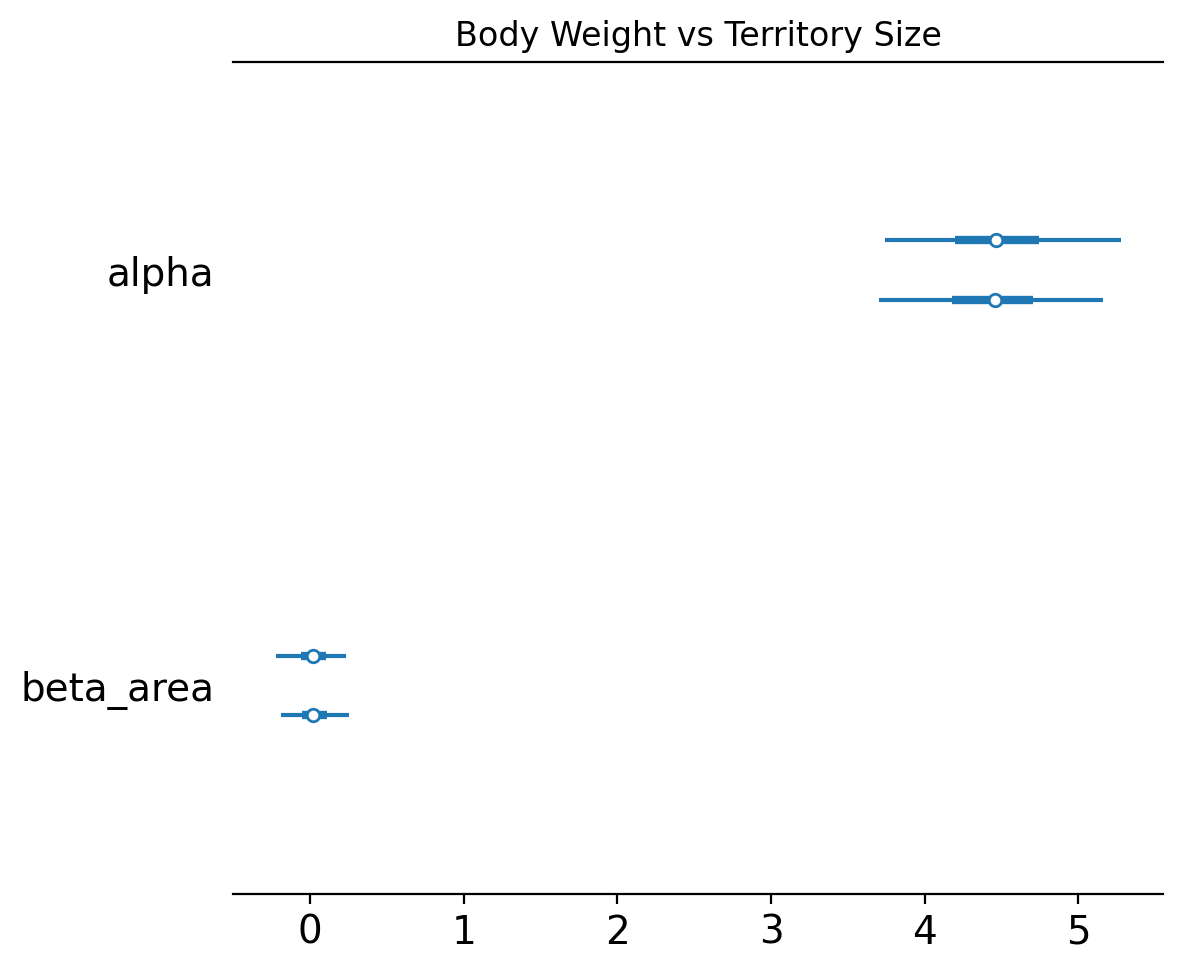

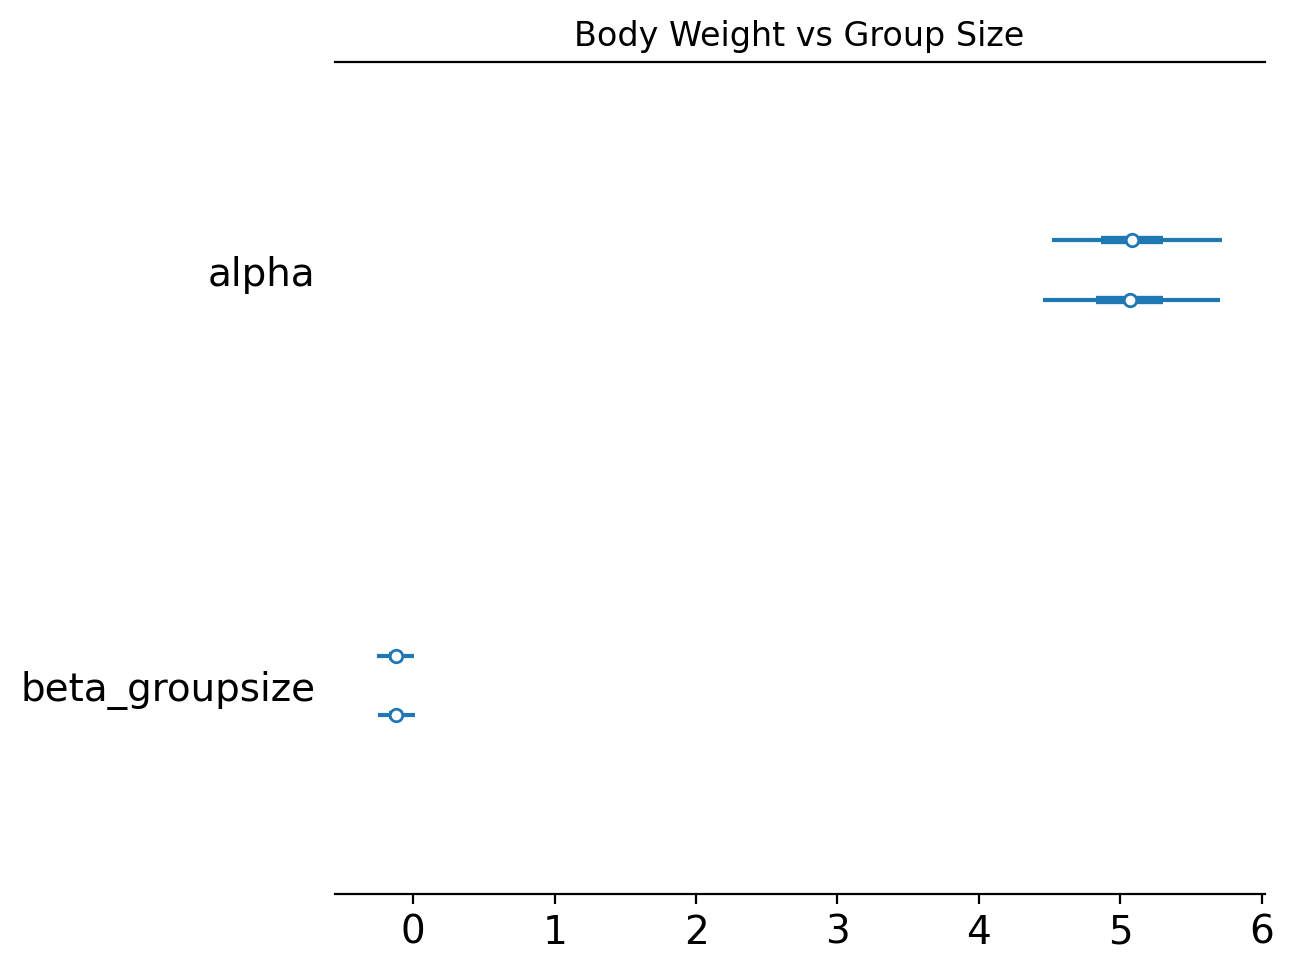

In [ ]:
az.plot_forest(trace_area, var_names=['alpha', 'beta_area'])
plt.title('Body Weight vs Territory Size')
plt.show()

az.plot_forest(trace_groupsize, var_names=['alpha', 'beta_groupsize'])
plt.title('Body Weight vs Group Size')
plt.show()

These plots show the posterior distribution of the intercept and slope parameters for each model. We can examine the credible intervals to see the significance of each variable in predicting body weight. Since the credible interval includes zero, it suggests that the corresponding variable is likely not important for predicting body weight.

# B
Now fit a multiple linear regression with `weight` as the outcome and both `area` and `groupsize` as predictor variables. Plot the predictions of the model for each predictor, holding the other predictor constant at its mean. What does this model say about the importance of each variable? Why do you get different results than you got in the exercise just above?

In [ ]:
with pm.Model() as multiple_regression_model:
    alpha = pm.Normal('alpha', mu=0, sigma=10)
    beta_area = pm.Normal('beta_area', mu=0, sigma=10)
    beta_groupsize = pm.Normal('beta_groupsize', mu=0, sigma=10)

    mu = alpha + beta_area * fox_data['area'] + beta_groupsize * fox_data['groupsize']
    sigma = pm.HalfNormal('sigma', sigma=10)
    weight = pm.Normal('weight', mu=mu, sigma=sigma, observed=fox_data['weight'])

    trace_multiple_regression = pm.sample(2000, tune=1000, target_accept=0.95)

In [ ]:
mean_area = fox_data['area'].mean()
mean_groupsize = fox_data['groupsize'].mean()

area_values = np.linspace(fox_data['area'].min(), fox_data['area'].max(), 100)
groupsize_values = np.repeat(mean_groupsize, 100)

weight_pred = trace_multiple_regression['beta_area'].mean(axis=0)

plt.figure(figsize=(12, 6))
plt.plot(area_values, weight_pred, label='Predictions (mean groupsize)')
plt.fill_between(area_values, *np.percentile(post_pred['weight'], [2.5, 97.5], axis=0), alpha=0.3, color='gray', label='95% CI')
plt.scatter(fox_data['area'], fox_data['weight'], color='red', label='Data')
plt.xlabel('Territory Size (area)')
plt.ylabel('Body Weight')
plt.title('Multiple Linear Regression: Body Weight vs Territory Size')
plt.legend()
plt.show()

KeyError: 'beta_area'

# C
Finally, consider the `avgfood` variable. Fit two more multiple regressions: (1) body weight as an additive function of `avgfood` and `groupsize`, and (2) body weight as an additive function of all three variables, `avgfood` and `groupsize` and `area`. Compare the results of these models to the previous models you've fit, in the first two exercises. (a) Is `avgfood` or `area` a better predictor of body weight? If you had to choose one or the other to include in a model, which would it be? Support your assessment with any tables or plots you choose. (b) When both `avgfood` or `area` are in the same model, their effects are reduced (closer to zero) and their standard errors are larger than when they are included in separate models. Can you explain this result?

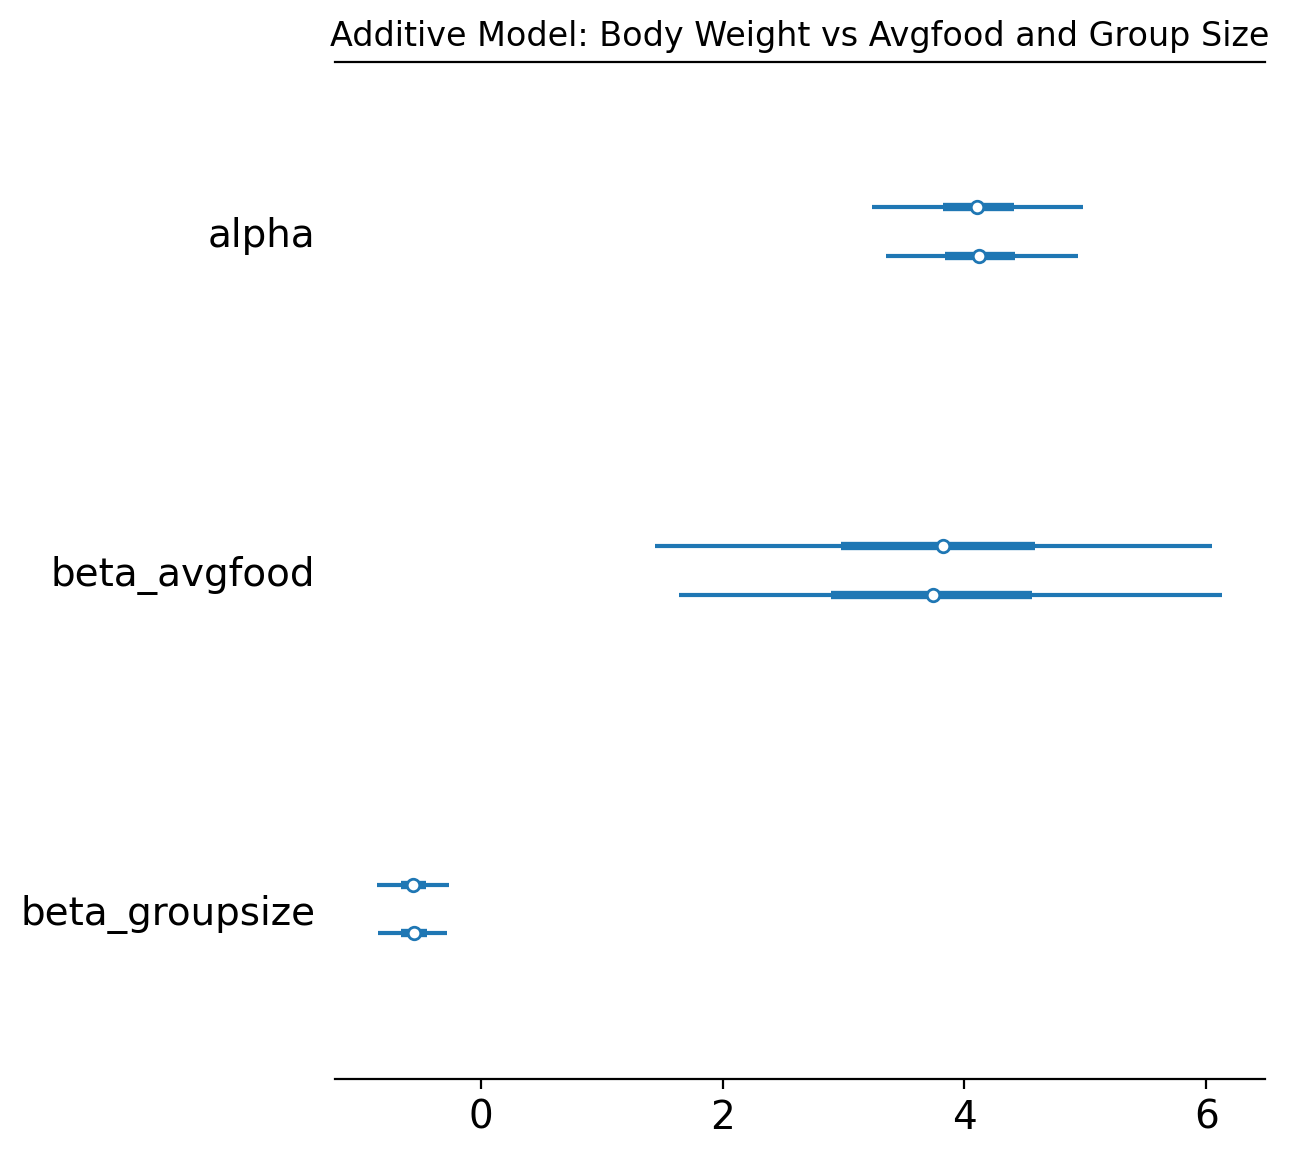

In [ ]:
with pm.Model() as additive_model:
    alpha = pm.Normal('alpha', mu=0, sigma=10)
    beta_avgfood = pm.Normal('beta_avgfood', mu=0, sigma=10)
    beta_groupsize = pm.Normal('beta_groupsize', mu=0, sigma=10)

    mu = alpha + beta_avgfood * fox_data['avgfood'] + beta_groupsize * fox_data['groupsize']
    sigma = pm.HalfNormal('sigma', sigma=10)
    weight = pm.Normal('weight', mu=mu, sigma=sigma, observed=fox_data['weight'])

    trace_additive_model = pm.sample(2000, tune=1000, target_accept=0.95)

az.plot_forest(trace_additive_model, var_names=['alpha', 'beta_avgfood', 'beta_groupsize'])
plt.title('Additive Model: Body Weight vs Avgfood and Group Size')
plt.show()

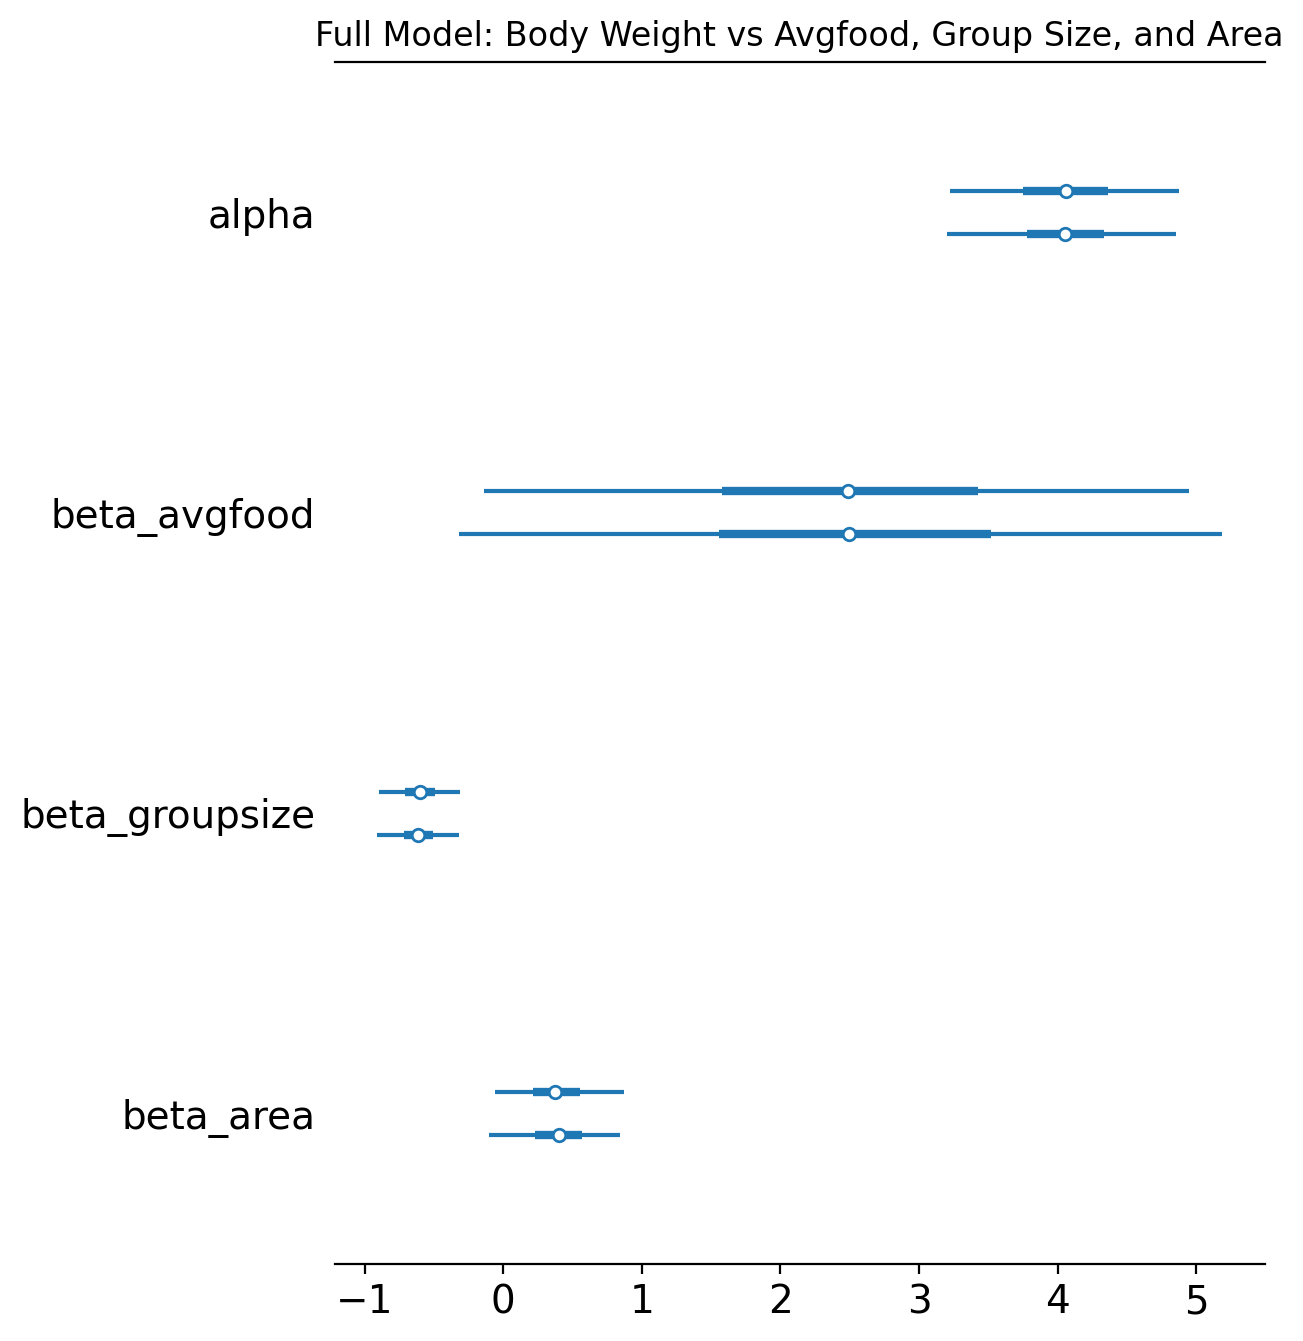

In [ ]:
with pm.Model() as full_model:
    alpha = pm.Normal('alpha', mu=0, sigma=10)
    beta_avgfood = pm.Normal('beta_avgfood', mu=0, sigma=10)
    beta_groupsize = pm.Normal('beta_groupsize', mu=0, sigma=10)
    beta_area = pm.Normal('beta_area', mu=0, sigma=10)

    mu = alpha + beta_avgfood * fox_data['avgfood'] + beta_groupsize * fox_data['groupsize'] + beta_area * fox_data['area']
    sigma = pm.HalfNormal('sigma', sigma=10)
    weight = pm.Normal('weight', mu=mu, sigma=sigma, observed=fox_data['weight'])

    trace_full_model = pm.sample(2000, tune=1000, target_accept=0.95)

az.plot_forest(trace_full_model, var_names=['alpha', 'beta_avgfood', 'beta_groupsize','beta_area'])
plt.title('Full Model: Body Weight vs Avgfood, Group Size, and Area')
plt.show()

In [ ]:
print(pm.summary(trace_additive_model))

# Display summary statistics for the full model
print(pm.summary(trace_full_model))

                 mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
alpha           4.122  0.446   3.311    4.984      0.010    0.007    1813.0   
beta_avgfood    3.759  1.221   1.553    6.126      0.031    0.022    1511.0   
beta_groupsize -0.557  0.156  -0.862   -0.278      0.004    0.003    1640.0   
sigma           1.142  0.076   1.006    1.291      0.002    0.001    1991.0   

                ess_tail  r_hat  
alpha             2103.0    1.0  
beta_avgfood      1720.0    1.0  
beta_groupsize    1654.0    1.0  
sigma             1749.0    1.0  
                 mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
alpha           4.053  0.442   3.257    4.915      0.009    0.006    2613.0   
beta_avgfood    2.504  1.438  -0.141    5.154      0.032    0.024    2021.0   
beta_groupsize -0.608  0.158  -0.911   -0.318      0.003    0.002    2096.0   
beta_area       0.390  0.252  -0.083    0.860      0.005    0.004    2572.0   
sigma           1.137  0.078   1.003   

Average food is a better predictor of body weight. Hence, I would choose to include average food in a given model. This is evident from the plots. When average food and area are in the same model, we get that the effects are reduced because they sort of "cancel" each other out.